In [2]:
import os
import pickle
from pathlib import Path

import cv2
import h5py
import joypy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from matplotlib import cm

load_dotenv()

RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR'))
PREPROCESSED_DATA_DIR = Path(os.getenv('PREPROCESSED_DATA_DIR'))

# Results Analysis

In [2]:
filepath = '../results/rPPG_Study_cv_results_new_w_hist.pkl'
with open(filepath, 'rb') as f:
    raw_results = pickle.load(f)

In [26]:
results = pd.DataFrame()
for i, fold in enumerate(raw_results):
    study_df = fold['study'].trials_dataframe()
    study_df['fold'] = i + 1
    results = pd.concat([results, study_df])
results = (results
           .drop(columns=['number', 'datetime_start',
                          'datetime_complete', 'duration',
                          'system_attrs_completed_rung_0'])
           .reset_index(drop=True)
)
results

,value,params_HPF,params_LPF,params_base,params_blur,params_color_space,params_flip,params_high_pass,params_hist_crop,params_histogram,params_kernel_size,params_kernel_size_high_pass,params_lambda,params_midline_increment,params_scale,params_sharpen,params_times,state,fold
0,0.453234,2.175588,3.670275,NaN,median,YUV,NaN,None,NaN,equalization,3.0,NaN,51.560365,NaN,NaN,NaN,1.0,COMPLETE,1
1,0.428083,0.030420,3.861010,-8.075653,box,Luv,True,our_custom,True,matching,9.0,7.0,125.998722,-3.490820,1.252508,False,3.0,COMPLETE,1
2,0.415570,4.638086,2.780612,NaN,None,Lab,NaN,None,NaN,None,NaN,NaN,188.119694,NaN,NaN,NaN,NaN,COMPLETE,1
3,0.171083,1.871557,0.425732,NaN,median,RGB,NaN,None,NaN,equalization,3.0,NaN,192.311008,NaN,NaN,NaN,4.0,COMPLETE,1
4,0.462256,0.129405,4.674357,NaN,gaussian,RGB,NaN,None,True,matching,9.0,NaN,136.576015,NaN,NaN,NaN,3.0,COMPLETE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.033872,4.792253,1.009927,-2.192777,box,RGB,True,our_custom,NaN,equalization,5.0,3.0,178.928626,4.143867,1.914337,False,1.0,COMPLETE,5
1246,0.032964,4.918280,1.037728,4.884792,box,RGB,True,our_custom,NaN,equalization,5.0,9.0,177.438273,4.204087,1.321520,False,1.0,COMPLETE,5
1247,0.284388,4.668224,1.226941,5.379408,box,RGB,True,our_custom,False,matching,5.0,9.0,176.931689,4.479311,1.241385,False,1.0,PRUNED,5
1248,0.035627,4.998250,1.064683,4.949035,box,RGB,True,our_custom,NaN,equalization,5.0,9.0,178.227874,4.142856,1.308173,False,1.0,COMPLETE,5


## Best Combinations

Best combination for each fold:

In [36]:
best_combinations = (results.fillna('-').loc[results.groupby('fold')['value'].idxmin()]
                    .set_index('fold')
                    .drop(columns='state')
                    .rename(columns={'value': 'MAPE'} | {c: c.replace('params_', '') for c in results.columns if c.startswith('params_')})
                    .T
)

best_combinations.style.format(precision=3)

fold,1,2,3,4,5
MAPE,0.033,0.026,0.039,0.034,0.032
HPF,3.888,4.284,1.725,3.919,4.884
LPF,1.035,1.286,1.029,1.046,1.003
base,-,-5.036,-,-,0.869
blur,-,gaussian,gaussian,-,box
color_space,RGB,RGB,RGB,RGB,RGB
flip,-,True,-,-,False
high_pass,-,our_custom,-,-,our_custom
hist_crop,-,-,-,-,-
histogram,equalization,equalization,equalization,equalization,equalization


# Visualize Best Parameter Configurations

In [8]:
with h5py.File(PREPROCESSED_DATA_DIR / 'foreheads_all.h5') as f:
    sub1 = np.array(f['subject1'])
    sub2 = np.array(f['subject1'])

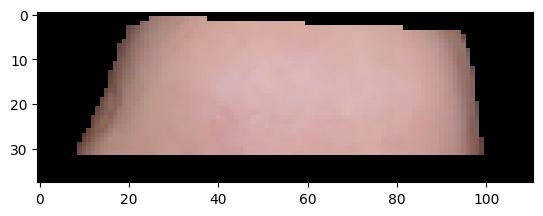

In [4]:
plt.imshow(sub1[0])

In [5]:
def custom_hpf(frame, k, base, midline_increment, scale, sharpen, flip):
    custom_filter = np.zeros([k,k])
    axis_2=int((k-1)/2)
    quarter = np.zeros([axis_2, axis_2])
    for i in np.arange(axis_2):
        for j in np.arange(axis_2):
            quarter[j,i]= -(base+(i+j)*scale)
    midline =  quarter[axis_2-1] + midline_increment
    custom_filter[:axis_2,:axis_2] = quarter
    custom_filter[axis_2+1:,:axis_2] = np.flip(quarter,axis=0)
    custom_filter[axis_2+1:,axis_2+1:] =  -1*np.flip(np.flip(quarter,axis=0),axis=1)
    custom_filter[:axis_2,axis_2+1:] = -1*np.flip(quarter,axis=1)
    custom_filter[axis_2,axis_2+1:] =  -1* np.flip(midline)
    custom_filter[axis_2,:axis_2] = midline
    if sharpen:
        custom_filter[axis_2+1,axis_2+1] = 1
    if flip:
        custom_filter=custom_filter.T
    return cv2.filter2D(src=frame, ddepth=-1, kernel=custom_filter)

def equalize_histogram(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    frame[:,:,2] = cv2.equalizeHist(frame[:,:,2]) 
    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
    return frame
                       

In [6]:
def combination_1(frames):
    # histogram equalization
    new_frames = []
    for frame in frames:
        new_frame = equalize_histogram(frame.copy())
        new_frames.append(new_frame)
    return np.array(new_frames)


def combination_2(frames):
    # equalization -> 5 * lpf -> hpf
    new_frames = []
    for frame in frames:
        new_frame = equalize_histogram(frame.copy())
        for _ in range(5):
            new_frame = cv2.GaussianBlur(new_frame, (9, 9), 0)
        new_frame = custom_hpf(new_frame, 3, -5.036, 2.388, 1.851, True, True)
        new_frames.append(new_frame)
    return np.array(new_frames)


def combination_3(frames):
    # equalization -> lpf
    new_frames = []
    for frame in frames:
        new_frame = equalize_histogram(frame.copy())
        new_frame = cv2.GaussianBlur(new_frame, (9, 9), 0)
        new_frames.append(new_frame)
    return np.array(new_frames)


def combination_4(frames):
    # histogram equalization
    new_frames = []
    for frame in frames:
        new_frame = equalize_histogram(frame.copy())
        new_frames.append(new_frame)
    return np.array(new_frames)


def combination_5(frames):
    # equalization -> lpf -> hpf
    new_frames = []
    for frame in frames:
        new_frame = equalize_histogram(frame.copy())
        new_frame = cv2.GaussianBlur(new_frame, (5, 5), 0)
        new_frame = custom_hpf(new_frame, 3, 0.869, 3.875, 1.662, False, False)
        new_frames.append(new_frame)
    return np.array(new_frames)

combinations = {'combination 1': combination_1,
                'combination 2': combination_2,
                'combination 3': combination_3,
                'combination 4': combination_4,
                'combination 5': combination_5}

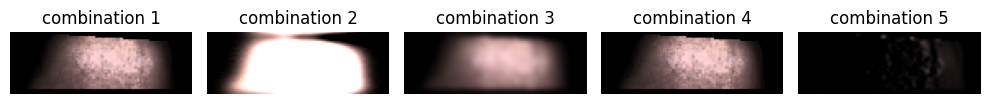

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(10, 7))

for com, ax in zip(combinations, axs.ravel()):
    ax.imshow(combinations[com](sub2)[300])
    ax.axis('off')
    ax.set_title(com)

plt.tight_layout()
plt.show()

## MAPE Distribution for Different Parameters

### Old joy-plots

In [5]:
def plot_joy(by: str, plot_title: str = None, df: pd.DataFrame = results):
    df = df[['value', f'params_{by}']].fillna('None')
    fig, ax = joypy.joyplot(df, by=f'params_{by}',
                            colormap=cm.viridis, fade=False, grid='y', overlap=2,
                            figsize=(6, 3))
    plt.xticks(np.arange(0, df['value'].max(), 0.1))
    plt.xlabel('MAPE')
    if plot_title is None:
        plot_title = by
    plt.title(f'MAPE Distribution by {plot_title}\nAcross all folds')
    plt.show()

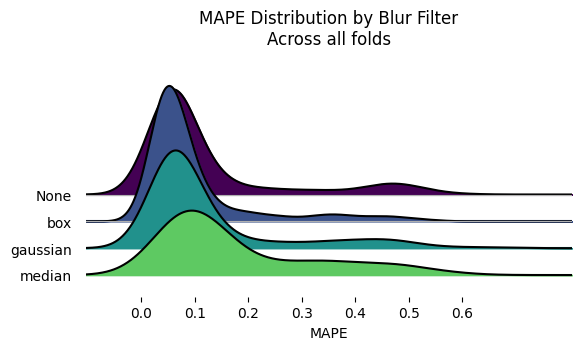

In [16]:
plot_joy('blur', 'Blur Filter')

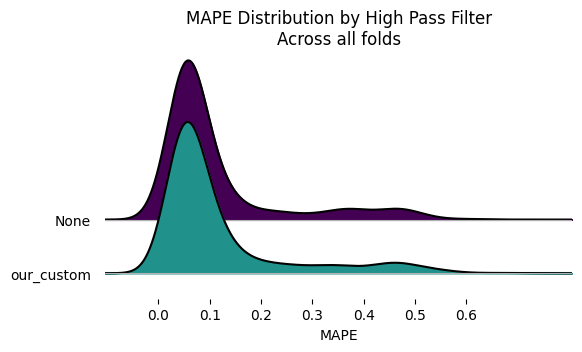

In [6]:
plot_joy('high_pass', 'High Pass Filter')

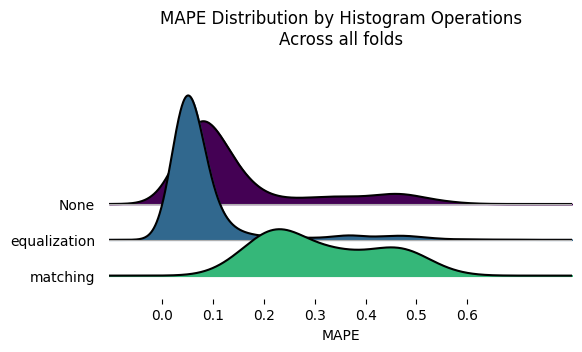

In [18]:
plot_joy('histogram', 'Histogram Operations')

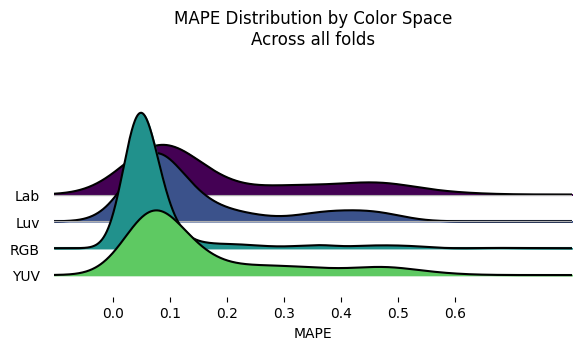

In [19]:
plot_joy('color_space', 'Color Space')

### New Plots

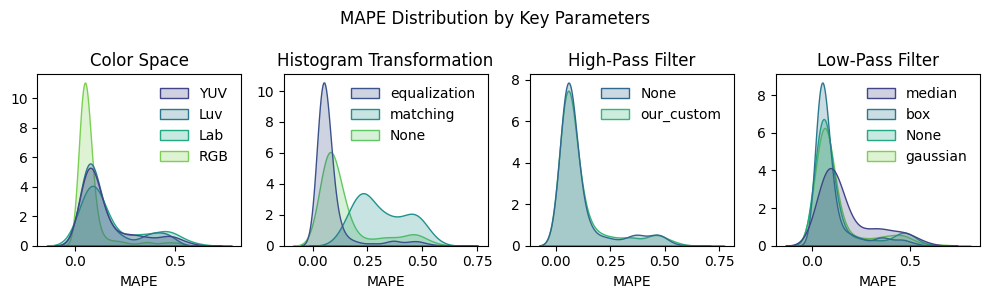

In [174]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
params = {'params_color_space': 'Color Space',
          'params_histogram':
          'Histogram Transformation',
          'params_high_pass': 'High-Pass Filter',
          'params_blur': 'Low-Pass Filter'}
for param, ax in zip(params, axs.ravel()):
    sns.kdeplot(results.fillna('None'), hue=param, x='value',
                fill=True, palette='viridis', ax=ax, common_norm=False)
    ax.set(xlabel='MAPE', title=params[param], ylabel='')
    sns.move_legend(ax, 'upper right', frameon=False,
                    title=None)
fig.suptitle('MAPE Distribution by Key Parameters')
plt.tight_layout()
plt.show()

Kernel parameters:

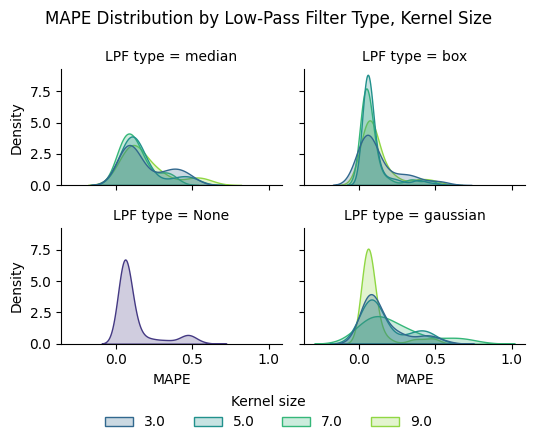

In [175]:
g = sns.displot(results.fillna({'params_blur': 'None', 'params_kernel_size': '_None'}),
                col='params_blur', x='value', hue='params_kernel_size',
                palette='viridis', kind='kde', fill=True, height=2, col_wrap=2,
                hue_order=['_None', 3.0, 5.0, 7.0, 9.0], common_norm=False)
g.set(xlabel='MAPE')
g.set_titles(col_template='LPF type = {col_name}')
sns.move_legend(g, 'lower center', ncol=4,
                bbox_to_anchor=(0.5, -0.1), title='Kernel size')
plt.suptitle('MAPE Distribution by Low-Pass Filter Type, Kernel Size')
plt.tight_layout()

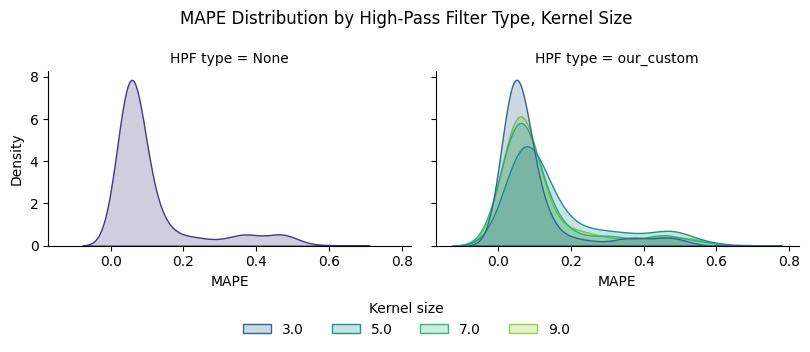

In [177]:
g = sns.displot(results.fillna({'params_high_pass': 'None', 'params_kernel_size_high_pass': '_None'}),
                col='params_high_pass', x='value', hue='params_kernel_size_high_pass',
                palette='viridis', kind='kde', fill=True, height=3, common_norm=False,
                hue_order=['_None', 3.0, 5.0, 7.0, 9.0]
                )
g.set(xlabel='MAPE')
g.set_titles(col_template='HPF type = {col_name}')
sns.move_legend(g, 'lower center', ncol=4, bbox_to_anchor=(
    0.5, -0.15), title='Kernel size')
plt.suptitle('MAPE Distribution by High-Pass Filter Type, Kernel Size')
plt.tight_layout()

In [163]:
results.columns

Index(['value', 'params_HPF', 'params_LPF', 'params_base', 'params_blur',
       'params_color_space', 'params_flip', 'params_high_pass',
       'params_hist_crop', 'params_histogram', 'params_kernel_size',
       'params_kernel_size_high_pass', 'params_lambda',
       'params_midline_increment', 'params_scale', 'params_sharpen',
       'params_times', 'state', 'fold'],
      dtype='object')

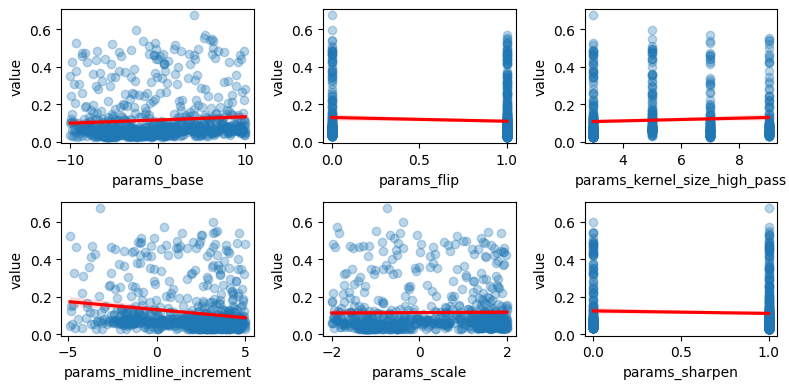

In [170]:
params = ['params_base', 'params_flip', 'params_kernel_size_high_pass', 'params_midline_increment',
          'params_scale', 'params_sharpen']

fig, axs = plt.subplots(2, 3, figsize=(8, 4))
for param, ax in zip(params, axs.ravel()):
    sns.regplot(results
                .query('params_high_pass == "our_custom"')[[param, 'value']]
                .astype('float64'),
                x=param, y='value', ax=ax, line_kws=dict(color='red'),
                scatter_kws=dict(alpha=0.3))
# plt.suptitle('MAPE Distribution by High-Pass Filter Type, Kernel Size')
plt.tight_layout()